In [24]:
import torch
from torch import nn
torch.cuda.is_available()
device = 'cpu'
from torchgeo.samplers import RandomGeoSampler, GridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples
import os
from torchgeo.datasets import RasterDataset
import pylab as plt
import numpy as np

/home/dkottke/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [68]:
class BengaluruDataset(RasterDataset):
    """
    Load xView3 polarization data that ends in *_dB.tif
    """
    
    #filename_glob = "*.tif"
    
    def __init__(self, root, filename_glob='*.tif', **kwargs):
        self.filename_glob = filename_glob
        super().__init__(root, **kwargs)
    

class BengaluruDatasetLabels(RasterDataset):
    """
    Load xView3 polarization data that ends in *_dB.tif
    """
    is_image = False
    filename_glob = "*.tif"

In [33]:
# base path of the dataset
TRAIN_PATH = os.path.join("Data", "Train")
TEST_PATH = os.path.join("Data", "Test")

tr_labels = lambda x: x[:,0,:,:].long()

class TransBengaluruImages(nn.Module):
    """."""

    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        inputs["image"] -= inputs["image"].min()
        inputs["image"] /= inputs["image"].max()
        
        return inputs
    
class TransBengaluruLabels(nn.Module):
    """."""

    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        # Batch
        if inputs["mask"].ndim == 4:
            inputs["mask"] = (inputs["mask"][:,0,:,:]).long()
        # Sample
        else:
            inputs["mask"] = (inputs["mask"][0,:,:]).long()
        
        return inputs

ds = BengaluruDataset(os.path.join(TRAIN_PATH, "Images"), transforms=TransBengaluruImages())
la = BengaluruDatasetLabels(os.path.join(TRAIN_PATH, "Labels"), transforms=TransBengaluruLabels())

train_ds = ds & la

ds2 = BengaluruDataset(os.path.join(TEST_PATH, "Images"), transforms=TransBengaluruImages())
la2 = BengaluruDatasetLabels(os.path.join(TEST_PATH, "Labels"), transforms=TransBengaluruLabels())

test_ds = ds2 & la2

In [50]:
la2._

False

In [53]:
from osgeo import gdal
ds = gdal.Open('Data/Test/Labels/Labelled_Post_P02.tif')

In [61]:
ds.GetGeoTransform()

(779700.306997573,
 1.200444240953174,
 0.0,
 1480999.4403944414,
 0.0,
 -1.2004442443570293)

In [62]:
sample

defaultdict(list,
            {'image': tensor([[[[0.1426, 0.1482, 0.1496,  ..., 0.1482, 0.1468, 0.1440],
                       [0.1369, 0.1383, 0.1440,  ..., 0.1440, 0.1412, 0.1440],
                       [0.1383, 0.1383, 0.1412,  ..., 0.1440, 0.1454, 0.1454],
                       ...,
                       [0.1482, 0.1482, 0.1412,  ..., 0.1637, 0.1651, 0.1666],
                       [0.1454, 0.1510, 0.1440,  ..., 0.1666, 0.1609, 0.1680],
                       [0.1482, 0.1482, 0.1454,  ..., 0.1623, 0.1623, 0.1680]],
             
                      [[0.1179, 0.1169, 0.1220,  ..., 0.1169, 0.1190, 0.1098],
                       [0.1057, 0.1047, 0.1128,  ..., 0.1149, 0.1159, 0.1128],
                       [0.1139, 0.1159, 0.1159,  ..., 0.1128, 0.1210, 0.1190],
                       ...,
                       [0.1087, 0.1098, 0.1026,  ..., 0.1578, 0.1486, 0.1640],
                       [0.1118, 0.1139, 0.1098,  ..., 0.1599, 0.1486, 0.1578],
                       [0.1128, 0

Data/Test/Images
WV_refl_B23567_P02.tif


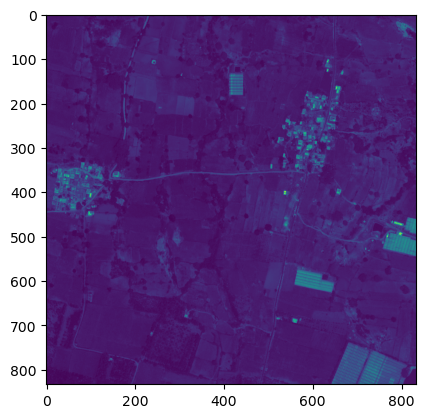

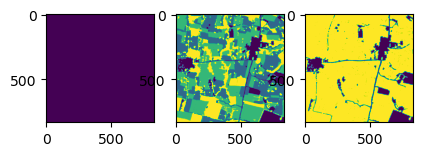

In [188]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

class GeoImage():
    def __init__(self, img_src, n_classes=4):
        self.img_src = img_src
        self.n_classes = n_classes
        
        self.ds = gdal.Open(self.img_src)
        self.band = self.ds.GetRasterBand(1)
        self.arr = self.band.ReadAsArray()
        
        img_src_split = img_src.split('/')
        print('/'.join(img_src_split[:-1]))
        print(img_src_split[-1])
        self.ds2 = BengaluruDataset('/'.join(img_src_split[:-1]), filename_glob=img_src_split[-1], transforms=TransBengaluruImages())

        self.predictions = np.zeros(self.arr.shape[:2], int)
        self.probabilities = np.zeros([self.n_classes, *self.arr.shape[:2]], float)
        
    def create_dataloader(self, size=128, batch_size=128, stride=110):
        self.sampler = GridGeoSampler(self.ds2, size=size, stride=stride, roi=None)
        dataloader  = DataLoader(self.ds2, batch_size, sampler=self.sampler, collate_fn=stack_samples)
        return dataloader
    
    def predict(self, net, dataloader=None, device='cpu'):
        if dataloader is None:
            dataloader = self.create_dataloader()
        
        for sample in dataloader:
            pred_batch = unet(sample["image"]).to(device)

            for idx, pred in enumerate(pred_batch):
                prob_numpy = pred.detach().numpy()
                pred_numpy = np.argmax(prob_numpy, 0)
                self.set_predictions(pred_numpy, sample['bbox'][idx])
                self.set_probabilities(prob_numpy, sample['bbox'][idx])
        
    def get_pixel_coordinates(self, bbox):
        org_b = self.ds2.bounds
        range_x = org_b.maxx - org_b.minx
        range_y = org_b.maxy - org_b.miny
        img_b = bbox
        minx_pi = int(np.round((img_b.minx - org_b.minx) / range_x * self.arr.shape[0]))
        #maxx_pi = minx_pi+128
        maxx_pi = int(np.round((img_b.maxx - org_b.minx) / range_x * self.arr.shape[0]))
        miny_pi = int(np.round((img_b.miny - org_b.miny) / range_y * self.arr.shape[1]))
        #maxy_pi = miny_pi+128
        maxy_pi = int(np.round((img_b.maxy - org_b.miny) / range_y * self.arr.shape[1]))
        
        return minx_pi, maxx_pi, miny_pi, maxy_pi
    
    def set_predictions(self, pred, bbox):
        minx_pi, maxx_pi, miny_pi, maxy_pi = self.get_pixel_coordinates(bbox)
        self.predictions[minx_pi:maxx_pi, miny_pi:maxy_pi] = np.rot90(pred, -1)
    
    def set_probabilities(self, prob, bbox):
        minx_pi, maxx_pi, miny_pi, maxy_pi = self.get_pixel_coordinates(bbox)
        self.probabilities[:, minx_pi:maxx_pi, miny_pi:maxy_pi] = np.rot90(prob, -1, axes=(1,2))
    
    def get_predictions(self):
        return np.rot90(self.predictions)
    
    def get_probabilities(self):
        return np.rot90(self.probabilities, axes=(1,2))
    
    def write_tif_files(self, name, folder=''):
        self.write_geotiff(f'{folder}{name}_pred.tif' , self.get_predictions())
        probs = self.get_probabilities()*1000
        for c in range(self.n_classes):
            self.write_geotiff(f'{folder}{name}_prob_class{c}.tif', probs[c])
    
    def write_geotiff(self, filename, arr):
        if arr.dtype == np.float32:
            arr_type = gdal.GDT_Float32
        else:
            arr_type = gdal.GDT_Int32

        driver = gdal.GetDriverByName("GTiff")
        out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
        out_ds.SetProjection(self.ds.GetProjection())
        out_ds.SetGeoTransform(self.ds.GetGeoTransform())
        band = out_ds.GetRasterBand(1)
        band.WriteArray(arr)
        band.FlushCache()
        band.ComputeStatistics(False)
        

def read_geotiff(filename):
    ds = gdal.Open(filename)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    return arr, ds


img = GeoImage('Data/Test/Images/WV_refl_B23567_P02.tif')

#nlcd01_arr, nlcd01_ds = read_geotiff('Data/Test/Labels/Labelled_Post_P02.tif')
#nlcd16_arr_img, nlcd16_ds_img = read_geotiff('Data/Test/Images/WV_refl_B23567_P02.tif')
nlcd16_arr, nlcd16_ds = read_geotiff('Data/Test/Labels/Labelled_Post_P02.tif')
#
nlcd_changed = np.where(nlcd16_arr != 0, 1, 0)
img.write_geotiff("nlcd_changed.tif", nlcd_changed)
#
#write_geotiff("nlcd_changed.tif", nlcd_changed, nlcd16_ds_img)
#
plt.imshow(img.arr)
plt.show()
#
plt.subplot(142)
plt.imshow(img.predictions)
#
plt.subplot(143)
plt.imshow(nlcd16_arr)
#
plt.subplot(144)
plt.imshow(nlcd_changed)
#
plt.show()

In [189]:
img.predict(unet)

In [207]:
from scipy.stats import entropy
from scipy.special import softmax

probs = softmax(img.get_probabilities(), axis=0)
entropy(probs, axis=0).mean()

0.21759310711514415

In [200]:
img.get_probabilities()

array([[[-3.22477198, -3.3932662 , -3.55633736, ..., -1.41579151,
         -1.32721806, -1.33211219],
        [-2.95683455, -3.46792316, -3.61175299, ..., -1.45768857,
         -1.23774052, -1.38541925],
        [-3.10111833, -3.63891745, -4.24056196, ..., -1.68449056,
         -1.50063264, -1.43229043],
        ...,
        [-3.69096184, -4.28915024, -4.24075985, ..., -0.68423671,
         -0.74486804, -0.75195372],
        [-3.2919066 , -3.63506174, -3.79689789, ..., -0.56462884,
         -0.77143764, -0.94329828],
        [-2.11186194, -2.37591195, -2.3700068 , ..., -0.73439527,
         -0.59167206, -1.015275  ]],

       [[-1.78514194, -2.07888794, -1.95863914, ...,  1.31939006,
          0.36732459,  1.07416368],
        [-1.53498173, -2.0274024 , -1.64933014, ...,  1.70570827,
          0.79339957,  1.38767815],
        [-1.14935255, -1.33206463, -1.49220419, ...,  2.79034758,
          1.94101298,  2.36237526],
        ...,
        [-4.86833763, -5.81025028, -5.53297138, ..., -

In [191]:
img.write_tif_files('p02')

In [166]:
dataloader = img.create_dataloader(size=128, stride=128, batch_size=128)
for sample in dataloader:
    pred_batch = unet(sample["image"]).to('cpu')
    
    for idx, pred in enumerate(pred_batch):
        prob_numpy = pred.detach().numpy()
        pred_numpy = np.argmax(prob_numpy, 0)
        img.set_predictions(prob_numpy[3], sample['bbox'][idx])
    
    #plt.imshow(image)
    #plt.show()

In [158]:
pred.shape

torch.Size([4, 128, 128])

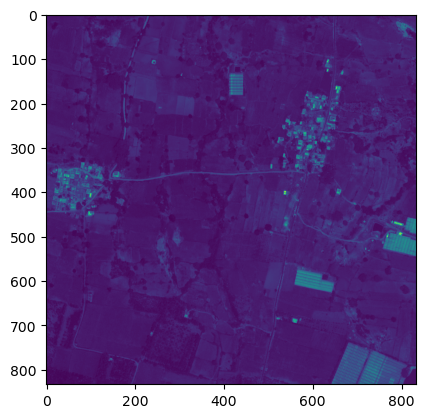

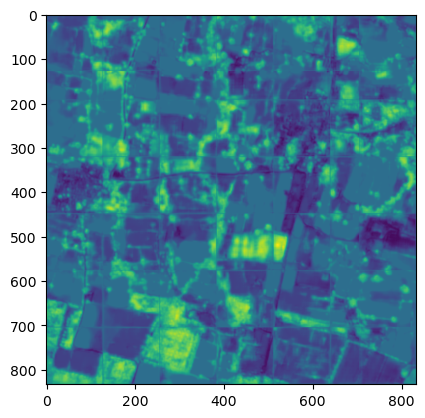

In [165]:
plt.imshow(img.arr)
plt.show()

plt.imshow(img.get_predictions())
plt.show()

img.write_predictions('pred_p02.tif')

In [91]:
sample['bbox']

[BoundingBox(minx=780546.6201888624, maxx=780700.2770517045, miny=1480845.7835315994, maxy=1480999.4403944414, mint=0.0, maxt=9.223372036854776e+18)]

In [89]:
img.ds2.bounds

BoundingBox(minx=779700.3069975728, maxx=780700.2770517045, miny=1479999.4703403097, maxy=1480999.4403944414, mint=0.0, maxt=9.223372036854776e+18)

In [116]:
n_pixels = 833

org_b = img.ds2.bounds
range_x = org_b.maxx - org_b.minx
range_y = org_b.maxy - org_b.miny
img_b = sample['bbox'][0]
minx_pi = int((img_b.minx - org_b.minx) / range_x * n_pixels)
maxx_pi = int((img_b.maxx - org_b.minx) / range_x * n_pixels)
miny_pi = int((img_b.miny - org_b.miny) / range_y * n_pixels)
maxy_pi = int((img_b.maxy - org_b.miny) / range_y * n_pixels)

print(minx_pi, maxx_pi, miny_pi, maxy_pi)

127 255 0 127


(128, 128)

In [34]:
DATASET_SIZE = 2048
BATCH_SIZE = 128
IMG_SIZE = 128


train_sampler = RandomGeoSampler(train_ds, size=IMG_SIZE, length=DATASET_SIZE)

# test_sampler = RandomGeoSampler(test_ds, size=IMG_SIZE, length=DATASET_SIZE)

test_sampler = GridGeoSampler(test_ds, size=IMG_SIZE, stride=110, roi=None)


train_dl = DataLoader(train_ds, BATCH_SIZE, sampler=train_sampler, collate_fn=stack_samples)
test_dl  = DataLoader(test_ds, 1, sampler=test_sampler, collate_fn=stack_samples)

In [21]:
n_grid = 8
print((n_grid*128-800) / n_grid)

28.0


In [27]:
test_dl.

In [35]:
def visualize(image, mask):
    """PLot images in one row."""
    fig = plt.figure(figsize=(16, 8))
    #plt.imshow(image[0].transpose(0,2), vmin=0, vmax=1)
    image /= image.numpy().max()
    plt.imshow(image, cmap='gray')
    #plt.imshow(image[0])
    if mask.max()>0:
        plt.imshow(mask/9, alpha=0.25, vmin=0, vmax=1, cmap='Set1', interpolation='nearest')
        
    cb = plt.colorbar(cmap='Dark2', ticks=np.linspace(0.5/9, 3.5/9, 4), boundaries=np.linspace(0,4/9,5))
    cb.set_ticklabels(['Background', 'Soil', 'Herbaceous', 'Woody'])
    plt.show()

In [38]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)
        self.conv4 = self.contract_block(128, 256, 3, 1)

        self.upconv4 = self.expand_block(256, 128, 3, 1)
        self.upconv3 = self.expand_block(128*2, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)

        upconv4 = self.upconv4(conv4)
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [39]:
unet = torch.load('unet_128px-4ly.pt', map_location=torch.device('cpu'))
unet.eval();

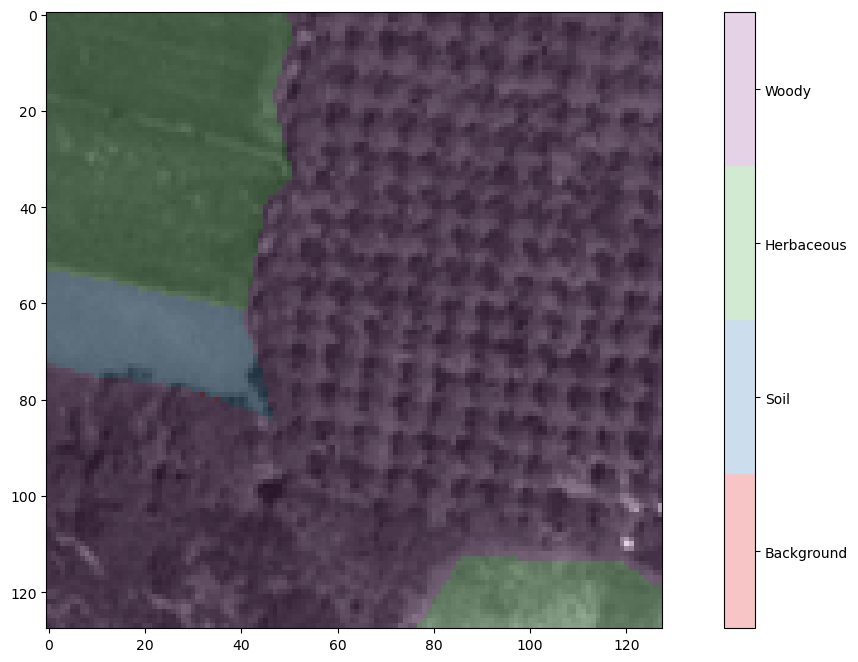

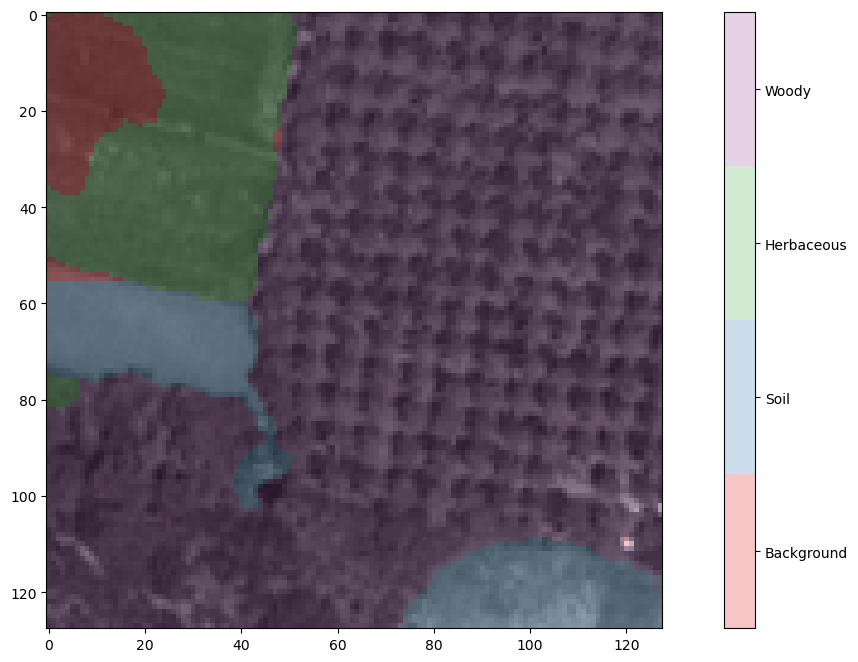

In [40]:
for sample in train_dl:
    idx = 0
    image = sample["image"].moveaxis(1,3)[idx, :, :, 1]
    target = sample["mask"][idx, :, :]
    pred = unet(sample["image"]).cpu()[0]

    visualize(image, target)
    visualize(image, torch.argmax(pred, 0))
    break

In [38]:
sample['mask'].shape

torch.Size([128, 128, 128])

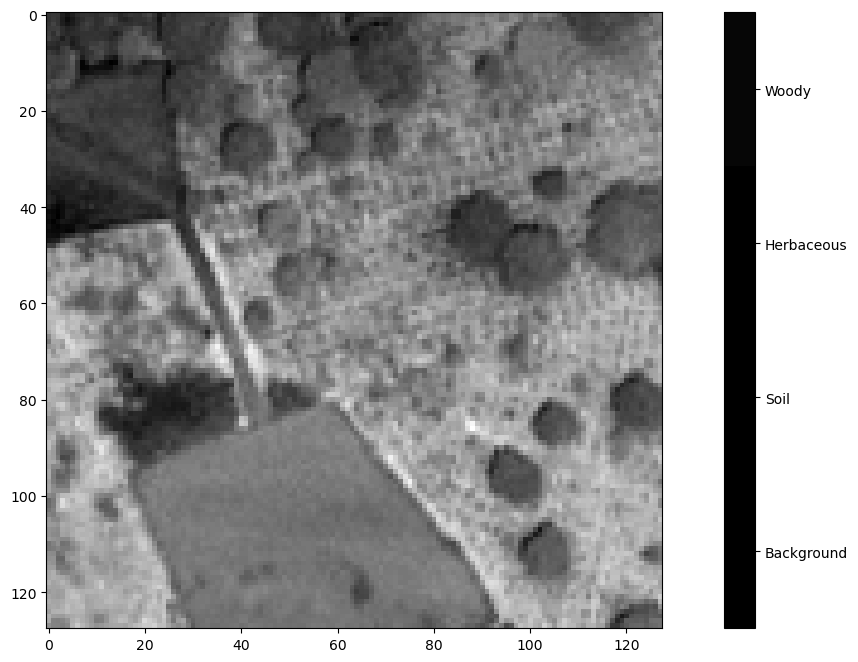

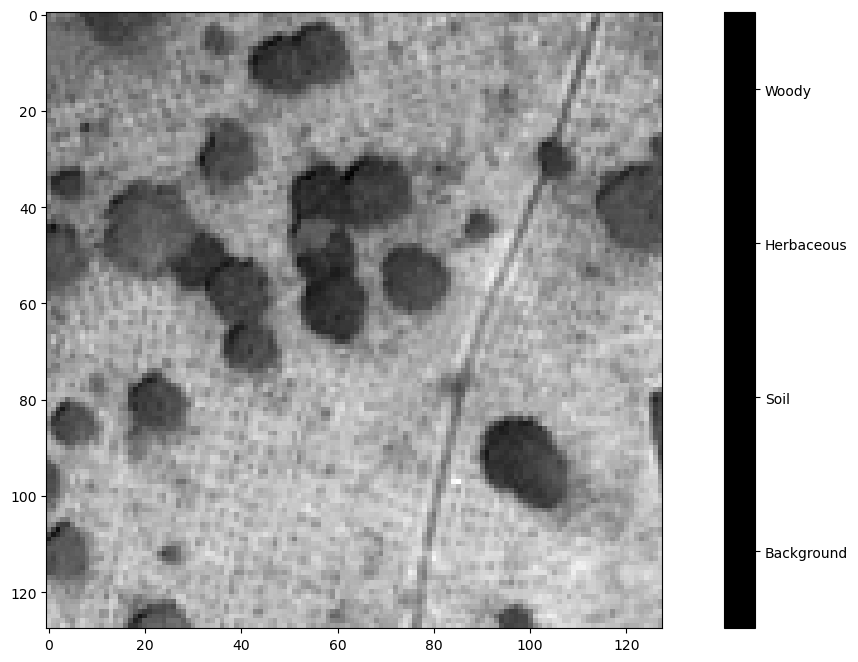

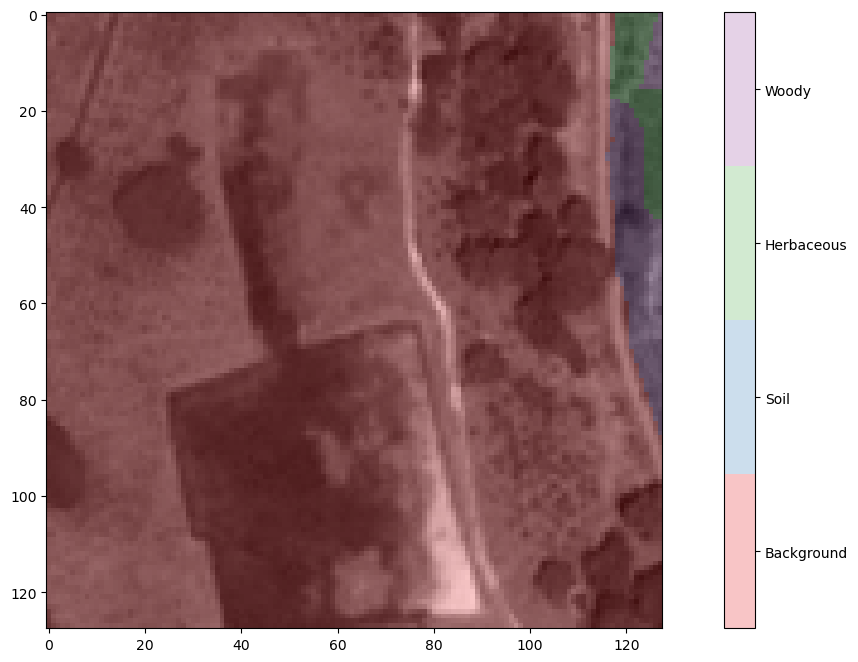

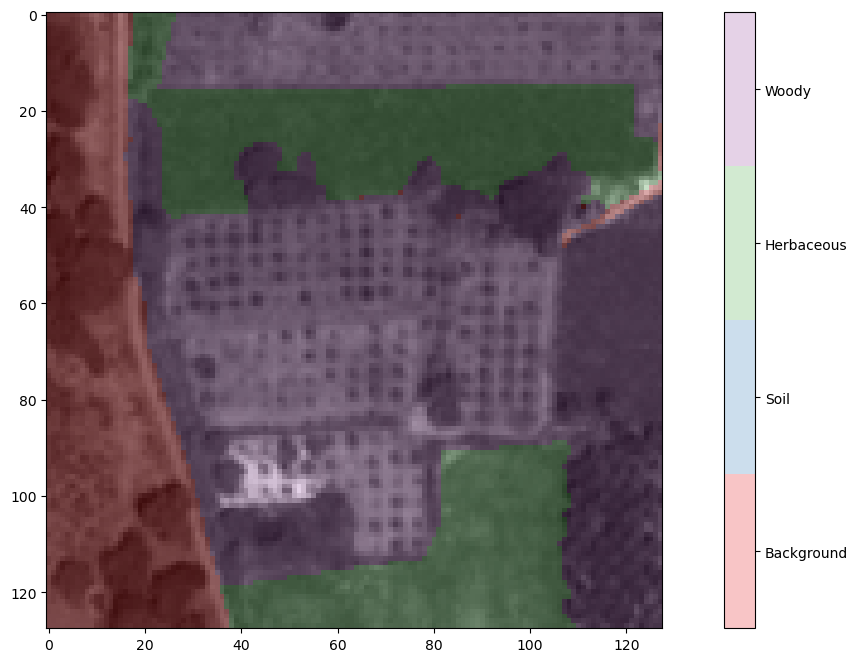

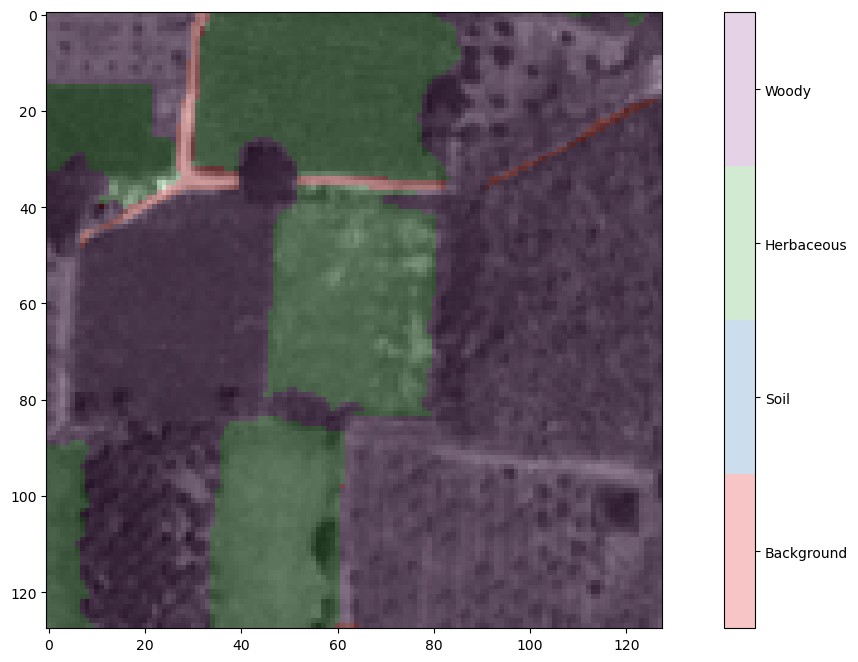

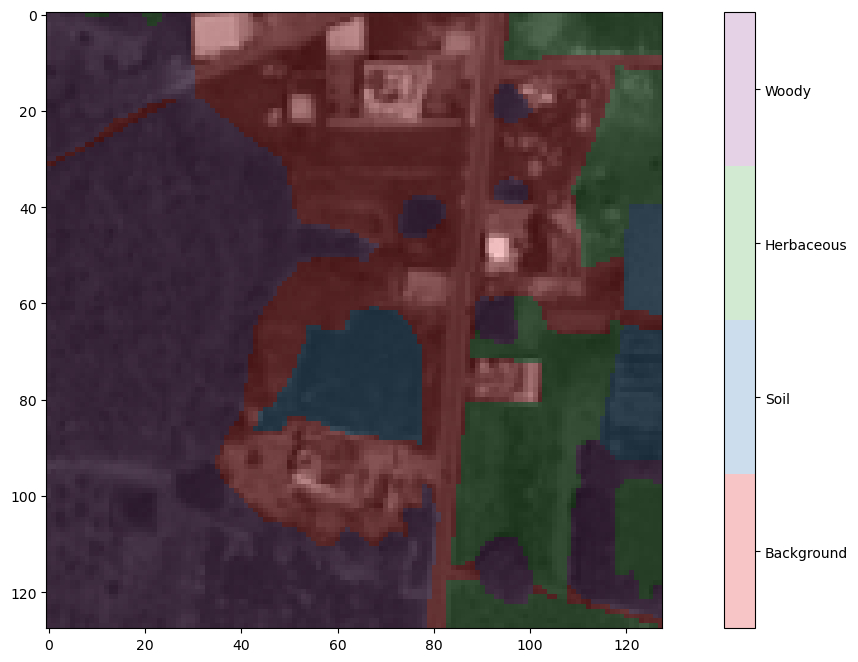

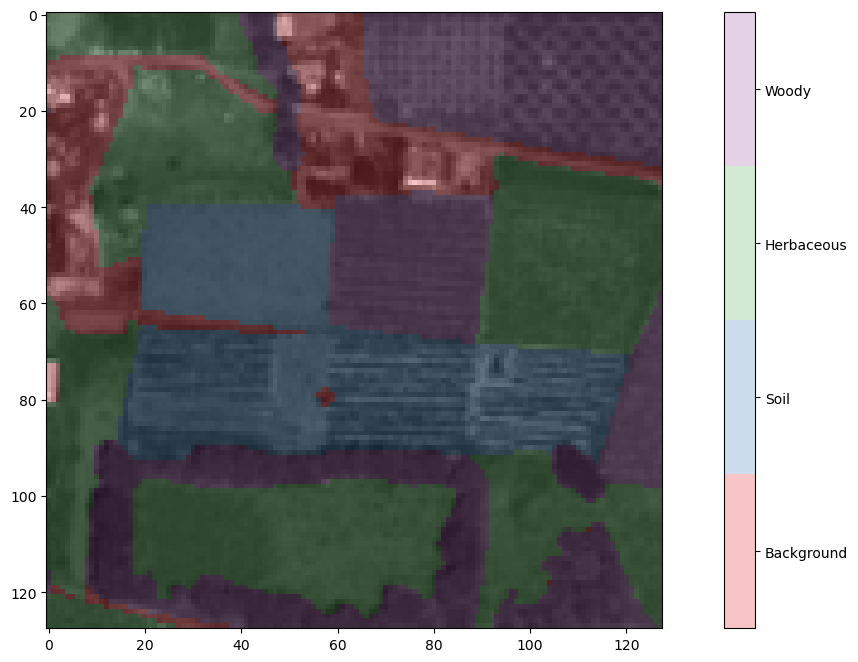

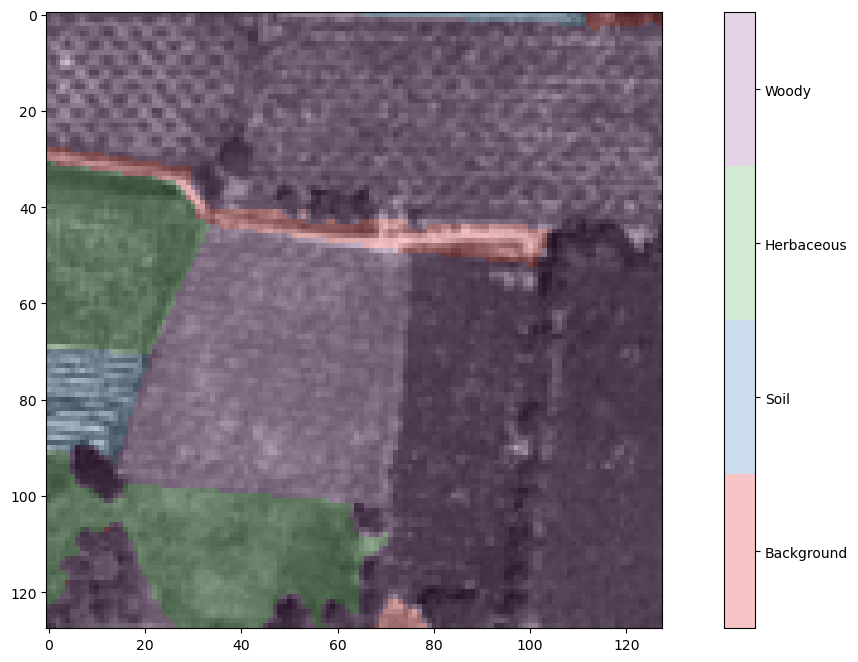

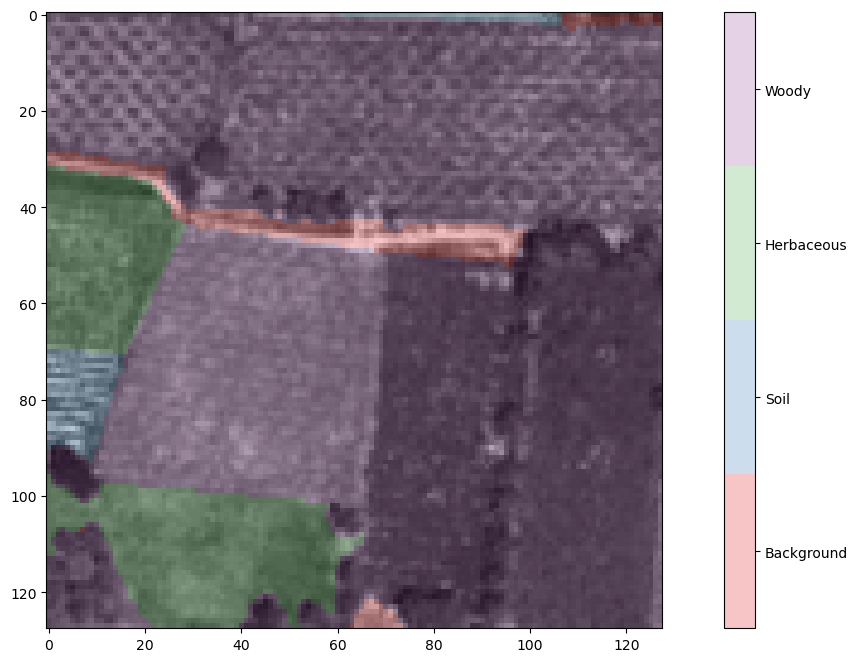

In [44]:
a = 1
for sample in test_dl:
    a += 1
    if a > 10:
        break
    
    idx = 0
    image = sample["image"].moveaxis(1,3)[idx, :, :, 1]
    target = sample["mask"][idx, :, :]
    pred = unet(sample["image"]).cpu()[0]

    visualize(image, target)
    #visualize(image, torch.argmax(pred, 0))

In [46]:
sample

defaultdict(list,
            {'image': tensor([[[[0.1426, 0.1482, 0.1496,  ..., 0.1482, 0.1468, 0.1440],
                       [0.1369, 0.1383, 0.1440,  ..., 0.1440, 0.1412, 0.1440],
                       [0.1383, 0.1383, 0.1412,  ..., 0.1440, 0.1454, 0.1454],
                       ...,
                       [0.1482, 0.1482, 0.1412,  ..., 0.1637, 0.1651, 0.1666],
                       [0.1454, 0.1510, 0.1440,  ..., 0.1666, 0.1609, 0.1680],
                       [0.1482, 0.1482, 0.1454,  ..., 0.1623, 0.1623, 0.1680]],
             
                      [[0.1179, 0.1169, 0.1220,  ..., 0.1169, 0.1190, 0.1098],
                       [0.1057, 0.1047, 0.1128,  ..., 0.1149, 0.1159, 0.1128],
                       [0.1139, 0.1159, 0.1159,  ..., 0.1128, 0.1210, 0.1190],
                       ...,
                       [0.1087, 0.1098, 0.1026,  ..., 0.1578, 0.1486, 0.1640],
                       [0.1118, 0.1139, 0.1098,  ..., 0.1599, 0.1486, 0.1578],
                       [0.1128, 0